In [156]:
import pandas as pd
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from torch.utils.data import TensorDataset, DataLoader
from packaging.version import parse
from transformers import AutoTokenizer, AutoModel
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from tqdm import tqdm
from sklearn.metrics import roc_auc_score, roc_curve

In [157]:
print(torch.__version__)
print(torch.cuda.is_available())
print(torch.cuda.get_device_name())

torch_cuda_version = parse(torch.version.cuda)
print(torch_cuda_version)a

device = "cuda:0" 

2.1.2+cu121
True
NVIDIA GeForce GTX 1070
12.1


In [158]:
tiny_bert_tokenizer = AutoTokenizer.from_pretrained("cointegrated/rubert-tiny")
tiny_bert = AutoModel.from_pretrained("cointegrated/rubert-tiny")
tiny_bert.cuda()

def embed_bert_cls(text, model, tokenizer):
    t = tokenizer(text, padding=True, truncation=True, return_tensors='pt')
    with torch.no_grad():
        model_output = model(**{k: v.to(model.device) for k, v in t.items()})
    embeddings = model_output.last_hidden_state[:, 0, :]
    embeddings = torch.nn.functional.normalize(embeddings)
    return embeddings[0].cpu().numpy()

print(embed_bert_cls('привет мир', tiny_bert, tiny_bert_tokenizer).shape)

(312,)


In [159]:
df = pd.read_csv('./data/shitpost_classification_df.csv', index_col=None)
df

,text,is_shitpost
0,последние годы Вера Васильевна работала над кн...,False
1,Население составляет человек г плотность насел...,False
2,Озеро Тоба находится зоне экваториального клим...,False
3,детстве хотелось укусить кошку думал,True
4,доказана доказана Брауном Бахлером году однако...,False
...,...,...
9954,люди задают вопрос зачем столько гинеса отвеча...,True
9955,декабря года вместе со другими архиереями УПЦ ...,False
9956,Цветы огромного большинства правильные редко с...,False
9957,день начинается английского английский начинае...,True


In [160]:
batch_size = 64
all_embeddings = []
for start in tqdm(range(0, len(df), batch_size), desc="Processing batches", unit="batch"):
    end = start + batch_size
    batch_data = df.iloc[start:end]

    t = tiny_bert_tokenizer(list(batch_data['text']), padding=True, truncation=True, return_tensors='pt')
    
    with torch.no_grad():
        t = {k: v.to(tiny_bert.device) for k, v in t.items()}
        model_output = tiny_bert(**t)
    
    embeddings = model_output.last_hidden_state[:, 0, :]
    embeddings = torch.nn.functional.normalize(embeddings)
        
    if start == 0:
        all_embeddings = embeddings
    else:
        all_embeddings = torch.cat((all_embeddings, embeddings), dim=0)

Processing batches: 100%|█████████████████████████████████████████████████████████| 156/156 [00:19<00:00,  7.94batch/s]


In [161]:
all_embeddings.shape

torch.Size([9959, 312])

In [162]:
target_tensor = torch.tensor(df['is_shitpost'].values)
target_tensor.shape

torch.Size([9959])

In [163]:
target_tensor.to(device)

tensor([False, False, False,  ..., False,  True, False], device='cuda:0')

In [164]:
values = torch.tensor([[1.0, 0.0], [0.0, 1.0]], device=device)
target_tensor = values[target_tensor.long()]

target_tensor

tensor([[1., 0.],
        [1., 0.],
        [1., 0.],
        ...,
        [1., 0.],
        [0., 1.],
        [1., 0.]], device='cuda:0')

In [165]:
all_embeddings

tensor([[ 6.3605e-02, -2.5677e-02,  3.7121e-03,  ..., -8.1519e-02,
         -5.3786e-03, -4.0399e-02],
        [ 8.2331e-02, -1.9753e-02,  9.8972e-03,  ..., -6.9441e-02,
          6.5619e-02, -5.2860e-03],
        [ 7.6314e-02,  3.8784e-02,  6.8614e-02,  ..., -5.8848e-05,
         -1.1515e-03, -1.3516e-02],
        ...,
        [ 9.8291e-02,  1.0354e-02, -2.8449e-02,  ..., -3.0498e-02,
          3.5797e-03, -3.2534e-02],
        [ 6.7740e-02, -6.4417e-02,  3.5072e-02,  ...,  9.0843e-02,
          1.3110e-02,  7.5751e-03],
        [-1.0775e-02,  7.2505e-03,  2.1809e-02,  ...,  3.5479e-02,
         -1.7865e-02, -3.7112e-02]], device='cuda:0')

In [166]:
all_embeddings_cpu = all_embeddings.cpu()
target_tensor_cpu = target_tensor.cpu()

train_size = 0.7
val_size = 0.1
test_size = 0.2

train_embeddings_cpu, temp_embeddings_cpu, train_targets_cpu, temp_targets_cpu = train_test_split(
    all_embeddings_cpu, target_tensor_cpu, train_size=train_size, stratify=target_tensor_cpu.numpy()
)

val_embeddings_cpu, test_embeddings_cpu, val_targets_cpu, test_targets_cpu = train_test_split(
    temp_embeddings_cpu, temp_targets_cpu, test_size=test_size / (val_size + test_size), stratify=temp_targets_cpu.numpy()
)

# Move data back to GPU after splitting
train_embeddings, train_targets = train_embeddings_cpu.to('cuda:0'), train_targets_cpu.to('cuda:0')
val_embeddings, val_targets = val_embeddings_cpu.to('cuda:0'), val_targets_cpu.to('cuda:0')
test_embeddings, test_targets = test_embeddings_cpu.to('cuda:0'), test_targets_cpu.to('cuda:0')

batch_size = 64

train_dataset = TensorDataset(train_embeddings, train_targets)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

val_dataset = TensorDataset(val_embeddings, val_targets)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)

test_dataset = TensorDataset(test_embeddings, test_targets)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)


In [167]:
loaders = {
    'train' : train_dataloader,
    'test' : test_dataloader,
    'val' : val_dataloader
}

In [168]:
class TLNetwork(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(input_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, output_size),
            nn.Softmax()
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.model(x)


In [169]:
input_size = 312
hidden_size = 312
output_size = 2
learning_rate = 0.01

criterion = nn.CrossEntropyLoss().to(device)

epochs = 1000

In [170]:
model = TLNetwork(input_size, hidden_size, output_size).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [171]:
def stop():
    raise Exception()

val_losses = []

for epoch in tqdm(range(epochs), desc="Learning", unit="epoch"):
    for x_batch, y_batch in train_dataloader:
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)
        model.train()
        optimizer.zero_grad()
        output = model(x_batch)
        loss = criterion(output, y_batch)
        loss.backward()
        optimizer.step()

    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for x_val_batch, y_val_batch in val_dataloader:
            x_val_batch, y_val_batch = x_val_batch.to(device), y_val_batch.to(device)
            val_output = model(x_val_batch)
            val_loss += criterion(val_output, y_val_batch).item()
    
    avg_val_loss = val_loss / len(val_dataloader)
    val_losses.append(avg_val_loss)


Learning:   0%|                                                                            | 0/1000 [00:00<?, ?epoch/s]C:\Users\Gleb\AppData\Local\Programs\Python\Python310\lib\site-packages\torch\nn\modules\module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
Learning: 100%|█████████████████████████████████████████████████████████████████| 1000/1000 [02:09<00:00,  7.71epoch/s]


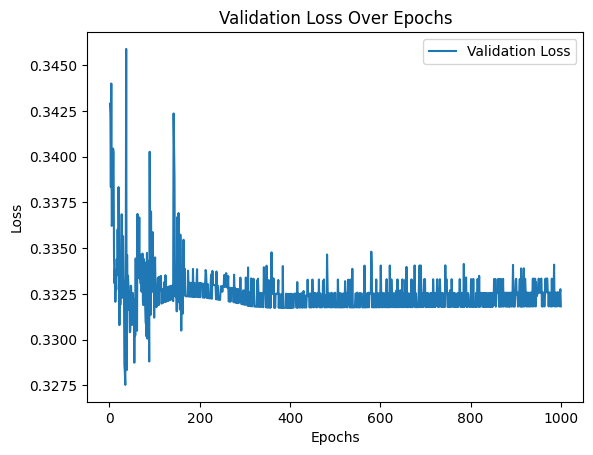

In [172]:

plt.plot(range(1, epochs + 1), val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Validation Loss Over Epochs')
plt.legend()
plt.show()


C:\Users\Gleb\AppData\Local\Programs\Python\Python310\lib\site-packages\torch\nn\modules\module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


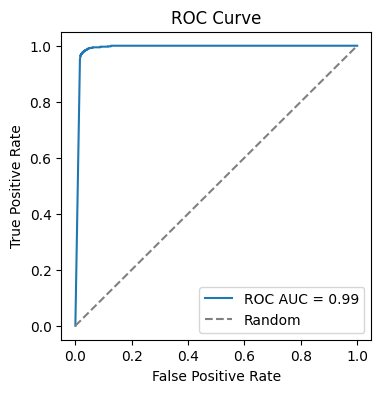

ROC AUC: 0.99


In [178]:
model.eval()
all_predictions = []
true_labels = []

with torch.no_grad():
    for x_test_batch, y_test_batch in test_dataloader:
        x_test_batch, y_test_batch = x_test_batch.to('cuda:0'), y_test_batch.to('cuda:0')
        test_output = model(x_test_batch)
        all_predictions.append(test_output.cpu())
        true_labels.append(y_test_batch.cpu())

all_predictions = torch.cat(all_predictions, dim=0)
true_labels = torch.cat(true_labels, dim=0)

binary_predictions = all_predictions[:, 1].cpu()

true_labels = true_labels[:, 1].long().cpu()

roc_auc = roc_auc_score(true_labels, binary_predictions)

fpr, tpr, _ = roc_curve(true_labels, binary_predictions)
plt.figure(figsize=(4, 4))
plt.plot(fpr, tpr, label=f'ROC AUC = {roc_auc:.2f}')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

print(f'ROC AUC: {roc_auc:.2f}')


In [175]:
binary_predictions = (all_predictions[:, 1] > 0.5).long()

accuracy = accuracy_score(true_labels, binary_predictions)
precision = precision_score(true_labels, binary_predictions)
recall = recall_score(true_labels, binary_predictions)
f1 = f1_score(true_labels, binary_predictions)
conf_matrix = confusion_matrix(true_labels, binary_predictions)

print(f'Test Accuracy: {accuracy * 100:.2f}%')
print(f'Precision: {precision:.2f}')
print(f'Recall: {recall:.2f}')
print(f'F1 Score: {f1:.2f}')
print('Confusion Matrix:')
print(conf_matrix)


Test Accuracy: 97.49%
Precision: 0.97
Recall: 0.97
F1 Score: 0.97
Confusion Matrix:
[[1087   23]
 [  27  855]]


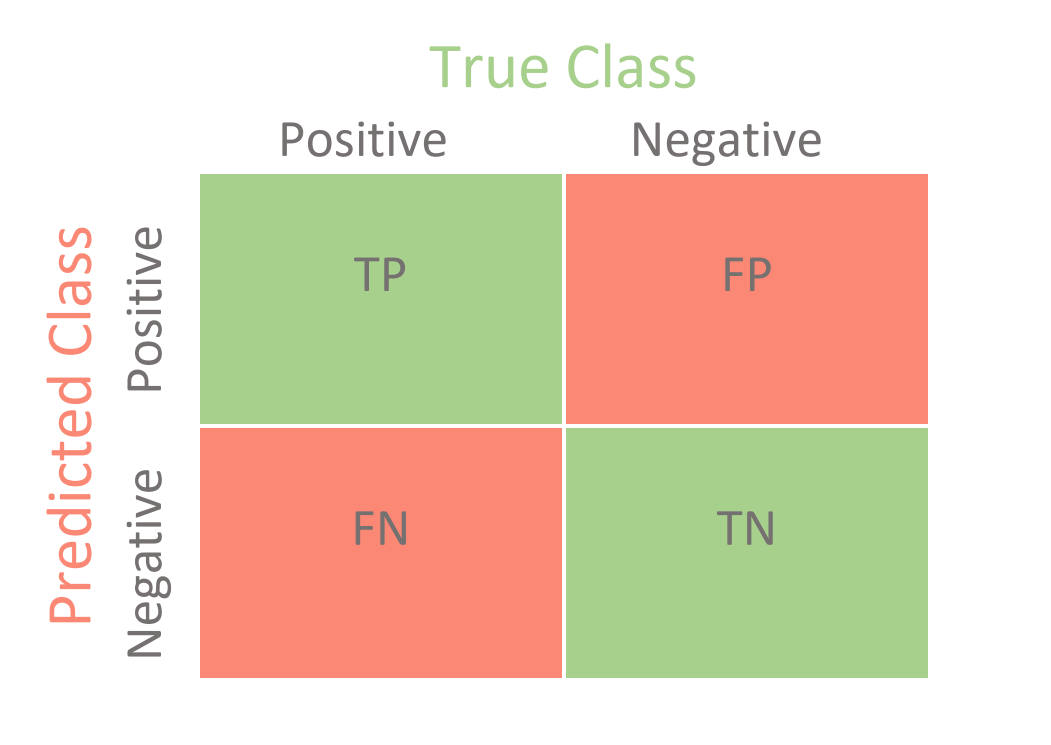

In [176]:
from IPython import display
display.Image("./confusion_matrix.png", width=600)

In [180]:
path_to_model = './shitpost_classifier.pt'
torch.save(model.state_dict(), path_to_model)